# Loading the Model
In this notebook we will try loading the model to make sure it properly works

In [6]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
import torch.optim as optim
import numpy as np
from src.config import PROCESSED_DATA_DIR
import matplotlib.pyplot as plt

from src.config import batch_size, image_size, nc, nz, ngf, ndf, num_epochs, lr, beta1, ngpu, MODELS_DIR
model_dir = MODELS_DIR / 'generator.pth'

In [7]:
print(model_dir)

C:\Git\art-generator\models\generator.pth


In [8]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()

        )

    def forward(self, input):
        return self.main(input)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
netG = Generator(ngpu=1).to(device)  # Use the same ngpu value as during training
netG.load_state_dict(torch.load(model_dir))

<All keys matched successfully>

# Generating Images with Loaded Model

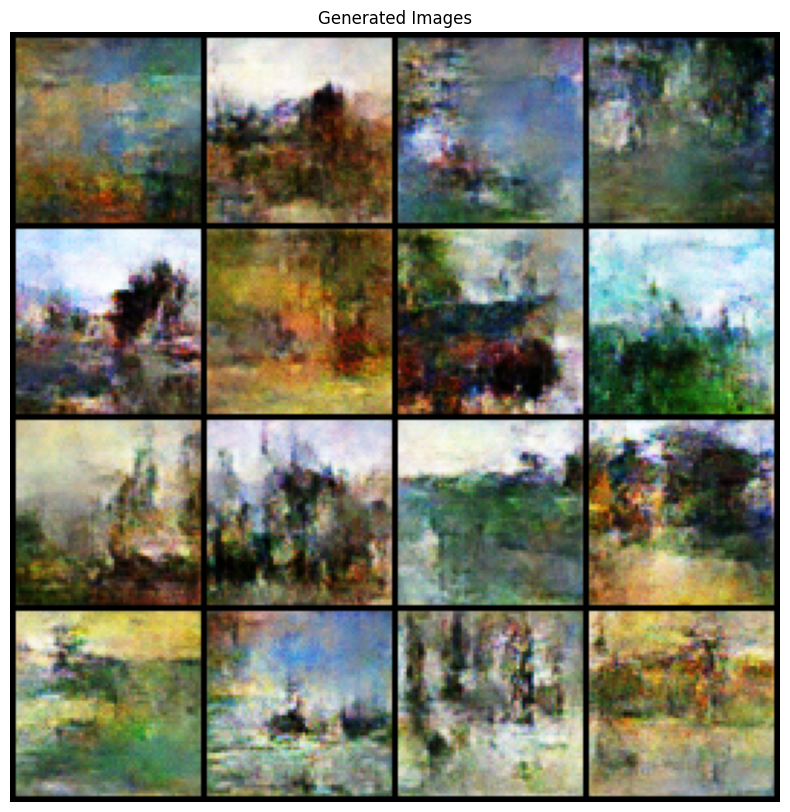

In [12]:
# Make sure your model is in evaluation mode
netG.eval()

# Set the number of images you want to generate
num_images = 16
batch_size = 16  # You can adjust this based on your GPU memory

# Create random noise vectors (this is what the generator transforms into images)
noise = torch.randn(num_images, nz, 1, 1, device=device)

# Generate images
with torch.no_grad():  # Disable gradient calculations for inference
    generated_images = netG(noise)

# Display the generated images using matplotlib
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

# Create a grid of images
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(
    vutils.make_grid(generated_images.detach().cpu(), 
                    nrow=4,  # Number of images per row
                    padding=2, 
                    normalize=True), 
    (1, 2, 0)  # Change from PyTorch's CHW format to matplotlib's HWC format
))
plt.show()

# If you want to save individual images to files
from PIL import Image
import torchvision.transforms as transforms

# Convert to PIL images and save
for i, img in enumerate(generated_images):
    # Transform tensor to PIL Image
    img = img.detach().cpu()
    img = img * 0.5 + 0.5  # Unnormalize if your output is in [-1,1] range
    img = transforms.ToPILImage()(img)
    
    # Save image
    img.save(f"generated_image_{i}.png")